## 1. Load libraries

In [1]:
import pandas as pd

In [2]:
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data
import torch_geometric.transforms as transforms

## 2. Read spatial data: Nigeria DHS 20-21

In [3]:
import geopandas as gpd
df = gpd.read_file("../data/nga_dhs20-21.shp")
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")
#gdf = gdf.to_crs("EPSG:32617")

In [4]:
gdf.geometry.centroid

C:\Users\girel\AppData\Local\Temp\ipykernel_14700\3951700624.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.centroid


0       POINT (8.50694 7.72005)
1       POINT (8.55214 7.71792)
2       POINT (8.99118 7.34660)
3       POINT (8.14976 7.21013)
4       POINT (8.40813 6.88090)
                 ...           
1384    POINT (3.58764 7.82843)
1385    POINT (3.34299 8.05012)
1386    POINT (3.01766 7.94763)
1387    POINT (3.29102 7.34129)
1388    POINT (3.94804 7.78566)
Length: 1389, dtype: geometry

In [5]:
centroids = np.array([(point.x, point.y) for point in df.geometry.centroid])
centroids.shape

C:\Users\girel\AppData\Local\Temp\ipykernel_14700\1084201971.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.array([(point.x, point.y) for point in df.geometry.centroid])


(1389, 2)

## 3. Build distance matrix

We build a proximity matrix between the clusters

In [6]:
from scipy.spatial.distance import cdist
distance_matrix = cdist(centroids, centroids, 'euclidean')

In [7]:
distance_matrix

array([[0.        , 0.04525601, 0.61152249, ..., 5.49399072, 5.22965119,
        4.55936917],
       [0.04525601, 0.        , 0.57501069, ..., 5.53924603, 5.27458718,
        4.60460133],
       [0.61152249, 0.57501069, 0.        , ..., 6.00368437, 5.70016848,
        5.06222254],
       ...,
       [5.49399072, 5.53924603, 6.00368437, ..., 0.        , 0.66511658,
        0.94437114],
       [5.22965119, 5.27458718, 5.70016848, ..., 0.66511658, 0.        ,
        0.79318793],
       [4.55936917, 4.60460133, 5.06222254, ..., 0.94437114, 0.79318793,
        0.        ]])

In [8]:
distance_matrix.shape

(1389, 1389)

In [9]:
max_distance = np.max(distance_matrix)
max_distance

18.817615452436154

In [10]:
weighted_proximity_matrix = np.zeros_like(distance_matrix)
for i in range(len(distance_matrix)):
    for j in range(len(distance_matrix)):
        proximity = (max_distance - distance_matrix[i, j]) / max_distance
        proximity = max(0, proximity)
        weighted_proximity_matrix[i, j] = proximity

In [11]:
print(weighted_proximity_matrix.min(),weighted_proximity_matrix.max())

0.0 1.0


In [12]:
threshold = 0.99
weighted_proximity_matrix[weighted_proximity_matrix < threshold] = 0

In [13]:
weighted_proximity_matrix

array([[1.        , 0.99759502, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.99759502, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [14]:
weighted_proximity_matrix[np.diag_indices_from(weighted_proximity_matrix)] = 0

## 4. Transform data to tensor

Create torch_geometric.data.Data object

Transform proximity matrix to tensor and create edges 

In [15]:
adj_matrix = torch.tensor(weighted_proximity_matrix)

In [16]:
edges = adj_matrix.nonzero().t().contiguous()

In [17]:
edges

tensor([[   0,    0,    0,  ..., 1388, 1388, 1388],
        [   1,    8,    9,  ..., 1358, 1380, 1383]])

Get edge attributes (given by proximity of clusters)

In [18]:
edge_attr = []
for i in range(edges.size(1)):
    edge_attr.append([adj_matrix[edges[0][i], edges[1][0]]])

edge_attr = torch.tensor(edge_attr, dtype=torch.float)

Prepare features

In [19]:
gdf.columns

Index(['dhsclst', 'd_cm', 'd_nutr', 'd_satt', 'd_educ', 'd_elct', 'd_wtr',
       'd_sani', 'd_hsg', 'd_ckfl', 'd_asst', 'score', 'sexfeml', 'sexmale',
       'agc70_4', 'a710_14', 'a715_17', 'a718_59', 'agc75_9', 'agc760_',
       'arearrl', 'arearbn', 'reginAb', 'rgnAdmw', 'rgnAk_I', 'rgnAnmb',
       'regnBch', 'rgnByls', 'reginBn', 'regnBrn', 'rgnCr_R', 'regnDlt',
       'rgnEbny', 'reginEd', 'regnEkt', 'regnEng', 'regnFCT', 'regnGmb',
       'reginIm', 'regnJgw', 'regnKdn', 'reginKn', 'rgnKtsn', 'regnKbb',
       'reginKg', 'regnKwr', 'regnLgs', 'rgnNsrw', 'regnNgr', 'regnOgn',
       'regnOnd', 'regnOsn', 'reginOy', 'regnPlt', 'rgnRvrs', 'regnSkt',
       'regnTrb', 'reginYb', 'rgnZmfr', 'hdshpf_', 'hdshpm_', 'categry',
       'geometry'],
      dtype='object')

In [20]:
features = list(gdf.columns[list(range(11, gdf.shape[1]-4))])

In [21]:
# Avoid multicollineality
for i in ['sexmale','agc760_','arearrl','reginAb','score']:#,'hdshpm_']:#,
         #'d_cm', 'd_nutr', 'd_satt', 'd_educ']:
    features.remove(i)

In [22]:
print(features)

['sexfeml', 'agc70_4', 'a710_14', 'a715_17', 'a718_59', 'agc75_9', 'arearbn', 'rgnAdmw', 'rgnAk_I', 'rgnAnmb', 'regnBch', 'rgnByls', 'reginBn', 'regnBrn', 'rgnCr_R', 'regnDlt', 'rgnEbny', 'reginEd', 'regnEkt', 'regnEng', 'regnFCT', 'regnGmb', 'reginIm', 'regnJgw', 'regnKdn', 'reginKn', 'rgnKtsn', 'regnKbb', 'reginKg', 'regnKwr', 'regnLgs', 'rgnNsrw', 'regnNgr', 'regnOgn', 'regnOnd', 'regnOsn', 'reginOy', 'regnPlt', 'rgnRvrs', 'regnSkt', 'regnTrb', 'reginYb', 'rgnZmfr']


In [23]:
x = torch.tensor(np.array(gdf[features]))
x.shape

torch.Size([1389, 43])

Target variable

In [24]:
task = "reg"

In [25]:
if task == "reg":
    target_tensor = torch.tensor(gdf['score'], dtype=torch.float)
else: 
    target = pd.Categorical(gdf['categry'])
    numerical_categories = target.codes
    print(np.unique(numerical_categories))
    target_tensor = torch.tensor(numerical_categories, dtype=torch.long) 
target_tensor

tensor([0.0804, 0.0678, 0.0451,  ..., 0.1570, 0.5354, 0.1026])

In [26]:
graph = torch_geometric.data.Data(x=x, edge_index=edges, edge_attr = edge_attr,y=target_tensor)
graph

Data(x=[1389, 43], edge_index=[2, 8956], edge_attr=[8956, 1], y=[1389])

<BarContainer object of 46 artists>

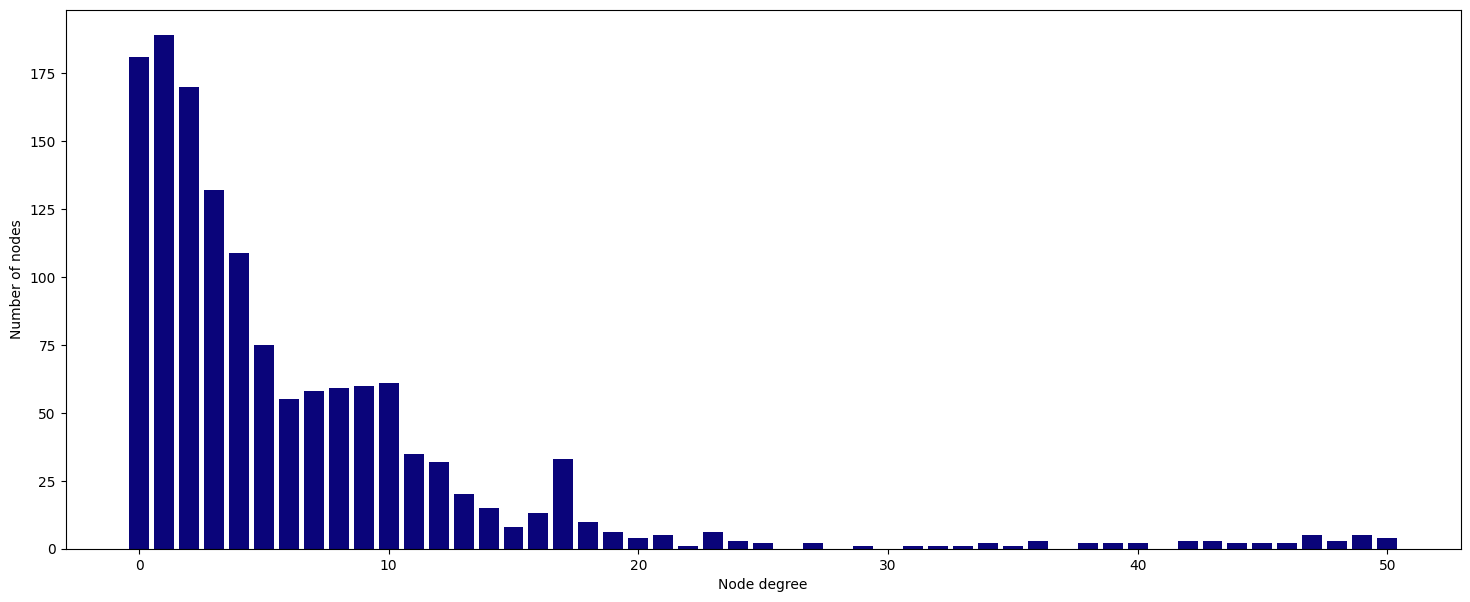

In [27]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(graph.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

In [28]:
from torch_geometric.loader import DataLoader

In [29]:
# Determine the number of nodes
num_nodes = graph.num_nodes
num_nodes

1389

In [30]:
# Calculate the sizes of the train, validation, and test sets
train_size = int(0.8 * num_nodes)
val_size = int(0.1 * num_nodes)
test_size = num_nodes - train_size - val_size
print(train_size, val_size, test_size)

1111 138 140


In [31]:
# Create random permutations of node indices
# Set the random seed
seed = 91218
torch.manual_seed(seed)
perm = torch.randperm(num_nodes)

# Create boolean masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[perm[:train_size]] = True
val_mask[perm[train_size:train_size + val_size]] = True
test_mask[perm[train_size + val_size:]] = True

# Add the masks to the graph object
graph.train_mask = train_mask
graph.val_mask = val_mask
graph.test_mask = test_mask

print(graph) #now the graph contains the masks.

Data(x=[1389, 43], edge_index=[2, 8956], edge_attr=[8956, 1], y=[1389], train_mask=[1389], val_mask=[1389], test_mask=[1389])


In [32]:
from torch_geometric.utils import subgraph
train_nodes = torch.where(train_mask)[0]
sub_edge_index, _ = subgraph(train_mask, graph.edge_index, relabel_nodes=True)
train_x = graph.x[train_nodes]
train_y = graph.y[train_nodes]
train_data = torch_geometric.data.Data(x=train_x, y=train_y, edge_index=sub_edge_index)
train_loader = torch_geometric.loader.DataLoader([train_data], batch_size=int(train_size//20), shuffle=True)

val_nodes = torch.where(val_mask)[0]
sub_edge_index, _ = subgraph(val_mask, graph.edge_index, relabel_nodes=True)
val_x = graph.x[val_nodes]
val_y = graph.y[val_nodes]
val_data = torch_geometric.data.Data(x=val_x, y=val_y, edge_index=sub_edge_index)
val_loader = torch_geometric.loader.DataLoader([val_data], batch_size=val_size)

test_nodes = torch.where(test_mask)[0]
sub_edge_index, _ = subgraph(test_mask, graph.edge_index, relabel_nodes=True)
test_x = graph.x[test_nodes]
test_y = graph.y[test_nodes]
test_data = torch_geometric.data.Data(x=test_x, y=test_y, edge_index=sub_edge_index)
test_loader = torch_geometric.loader.DataLoader([test_data], batch_size=test_size)

## 5. Prepare models

In [33]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, GATConv

In [34]:
class GAT(torch.nn.Module):
    """
    Graph Attention network
    """
    def __init__(self, dim_in, dim_h, dim_out, n_heads):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads = n_heads)
        self.norm1 = torch.nn.LayerNorm(dim_h * n_heads)
        self.gat2 = GATv2Conv(dim_h*n_heads, dim_out, heads = 1)
        self.norm2 = torch.nn.LayerNorm(16*n_heads)
        self.gat3 = GATv2Conv(n_heads*n_heads, 16, heads = 1)

    def forward(self, x, edge_index):
        x1 = F.dropout(x, p = 0.7, training = self.training)
        x = self.gat1(x1, edge_index)
        x = self.norm1(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gat2(x, edge_index)
        return x, F.log_softmax(x, dim=1)

In [35]:
dim_in = graph.x.size(1)  
dim_h = 32
if task == "reg":
    dim_out = 1
else:
    dim_out = len(graph.y.unique()) # Number of classes 
n_heads = 16

# Create an instance of your GAT model
model = GAT(dim_in, dim_h, dim_out, n_heads)
untrained = GAT(dim_in, dim_h, dim_out, n_heads)

In [36]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),weight_decay=5e-4)
if task == "reg":
    criterion = torch.nn.MSELoss()
else:
    criterion = torch.nn.CrossEntropyLoss()
n_epochs = 500

In [37]:
print(model)

GAT(
  (gat1): GATv2Conv(43, 32, heads=16)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (gat2): GATv2Conv(512, 1, heads=1)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (gat3): GATv2Conv(256, 16, heads=1)
)


In [38]:
def train(model, graph, optimizer, criterion):
    model.train()
    total_loss = 0
    num_batches = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out, log_probs = model(batch.x.float(), batch.edge_index)
        if task == "reg":
            y_pred = out
        else: 
            y_pred = log_probs
        y_true = batch.y.view(-1, 1)
        loss = criterion(y_pred, y_true) #only compute the loss on the train nodes.
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    return total_loss / num_batches

def test(model, graph, criterion, loader): #mask parameter added.
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in loader:
            out, log_probs = model(batch.x.float(), batch.edge_index)
            if task == "reg":
                y_pred = out
            else: 
                y_pred = log_probs
            y_true = batch.y.view(-1, 1)
            loss = criterion(y_pred, y_true) 
            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches

# Training loop
train_losses = []  # List to store losses
val_losses = []
test_losses = []
epochs_list = [] # List to store epoch numbers.
for epoch in range(n_epochs):
    train_loss = train(model, graph, optimizer, criterion)
    val_loss = test(model, graph, criterion, val_loader) #pass the validation mask
    test_loss = test(model, graph, criterion, test_loader) #pass the test mask
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    epochs_list.append(epoch + 1)
    print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/500, Train Loss: 3.1611, Val Loss: 0.5485, Test Loss: 0.5142
Epoch 2/500, Train Loss: 1.0613, Val Loss: 1.0655, Test Loss: 0.7528
Epoch 3/500, Train Loss: 0.9114, Val Loss: 2.2703, Test Loss: 1.8749
Epoch 4/500, Train Loss: 1.7039, Val Loss: 2.4458, Test Loss: 2.1222
Epoch 5/500, Train Loss: 1.6618, Val Loss: 1.8182, Test Loss: 1.6000
Epoch 6/500, Train Loss: 1.2538, Val Loss: 0.9754, Test Loss: 0.8505
Epoch 7/500, Train Loss: 0.8907, Val Loss: 0.3422, Test Loss: 0.2864
Epoch 8/500, Train Loss: 0.5680, Val Loss: 0.0800, Test Loss: 0.0642
Epoch 9/500, Train Loss: 0.5996, Val Loss: 0.0937, Test Loss: 0.0948
Epoch 10/500, Train Loss: 0.8361, Val Loss: 0.1689, Test Loss: 0.1700
Epoch 11/500, Train Loss: 0.9210, Val Loss: 0.1594, Test Loss: 0.1578
Epoch 12/500, Train Loss: 1.0134, Val Loss: 0.0834, Test Loss: 0.0852
Epoch 13/500, Train Loss: 0.7877, Val Loss: 0.0474, Test Loss: 0.0622
Epoch 14/500, Train Loss: 0.5946, Val Loss: 0.1258, Test Loss: 0.1600
Epoch 15/500, Train Loss: 0.5

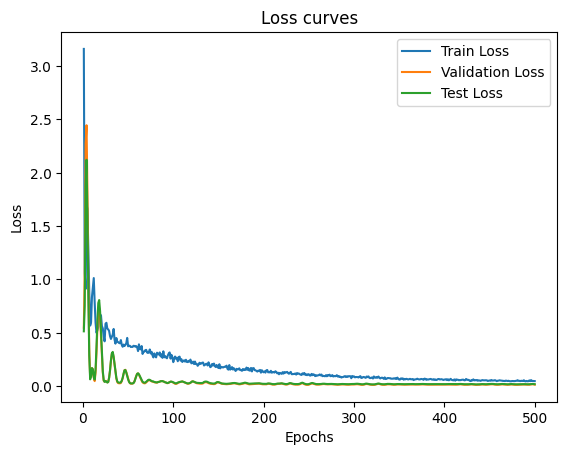

In [39]:
# Plotting the loss
plt.plot(epochs_list, train_losses, label = "Train Loss")
plt.plot(epochs_list, val_losses, label = "Validation Loss")
plt.plot(epochs_list, test_losses, label = "Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves')
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, r2_score
model.eval()
with torch.no_grad():
    for batch in test_loader:
        out, log_probs = model(batch.x.float(), batch.edge_index)
        ypred_gnn = out
        y_true = batch.y.view(-1, 1)
        val_mse = mean_squared_error(y_true, ypred_gnn)
        val_r2 = r2_score(y_true, ypred_gnn)
print(val_mse, val_r2)

0.01868731 0.47328401990411806


In [41]:
import networkx as nx

def pyg_to_networkx(graph_data):
    """Converts a torch_geometric.data.Data object to a networkx.Graph."""

    G = nx.Graph()

    # Add nodes with features
    for i, features in enumerate(graph_data.x.numpy()):
        G.add_node(i, features=features)

    # Add edges
    edge_list = graph_data.edge_index.numpy().T
    for u, v in edge_list:
        if graph_data.edge_attr is not None:
            edge_attr = graph_data.edge_attr[np.where((graph_data.edge_index[0] == u) & (graph_data.edge_index[1] == v))].numpy().flatten()
            G.add_edge(u, v, edge_attr=edge_attr)
        else:
            G.add_edge(u, v)

    return G

In [42]:
G = pyg_to_networkx(graph)

In [43]:
graph.x.numpy().shape
target = graph.y.numpy()

In [44]:
graph.x.size()

torch.Size([1389, 43])

In [50]:
from sklearn.metrics.pairwise import rbf_kernel
# 1. Compute Adjacency Kernel
K_adjacency = rbf_kernel(distance_matrix)

# 2. Compute Feature Kernel
K_features = rbf_kernel(gdf[features[10:]].to_numpy())

# 3. Combine Kernels (Weighted Summation)
alpha = 0.5  # Tune this parameter
K = alpha * K_adjacency + (1 - alpha) * K_features

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

X_train, X_test, y_train, y_test = train_test_split(K_features, target, test_size=0.2, random_state=91218)
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
y_pred = krr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Kernel Ridge Regression MSE: {mse}\t",f"Kernel Ridge Regression r-squared: {r2}\t")

svr = SVR() 
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)
print(f"Support Vector Regression MSE: {mse}\t",f"Support Vector Regression r-squared: {r2}\t")

Kernel Ridge Regression MSE: 0.01630047759084859	 Kernel Ridge Regression r-squared: 0.41395627233916776	
Support Vector Regression MSE: 0.015622909583880703	 Support Vector Regression r-squared: 0.43831656965770227	


In [47]:
if task == "reg":
    break

SyntaxError: 'break' outside loop (1273378216.py, line 2)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Get embeddings
h, _ = untrained(graph.x.float(), graph.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

unique_labels = np.unique(graph.y)
labels = ['Moderate Poor', 'Non-vulnerable', 'Severe Poor', 'Vulnerable']

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
# Scatter plot with different colors for each class
for label in unique_labels:
    indices = graph.y == label
    plt.scatter(tsne[indices, 0], tsne[indices, 1], s=20, label=labels[label])
    # Add legend
plt.legend(title="Class Labels", loc="upper right")
plt.show()

In [ ]:
h, _ = model(graph.x.float(), graph.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

unique_labels = np.unique(graph.y)
labels = ['Moderate Poor', 'Non-vulnerable', 'Severe Poor', 'Vulnerable']

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
# Scatter plot with different colors for each class
for label in unique_labels:
    indices = graph.y == label
    plt.scatter(tsne[indices, 0], tsne[indices, 1], s=20, label=labels[label])
# Add legend
plt.legend(title="Class Labels", loc="upper right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
model.eval()
output = model(graph.x.float(), graph.edge_index)
i, y_pred = output[1].max(1)
y_true = graph.y
cm = confusion_matrix(graph.y, y_pred)

In [ ]:
plt.figure(figsize=(len(labels),len(labels)))
cm_prop = cm.astype('float') / cm.sum(axis=1)
sns.heatmap(cm_prop, annot = True, xticklabels=labels, yticklabels=labels)
plt.show()

In [ ]:
plt.figure(figsize=(len(labels),len(labels)))
sns.heatmap(cm.astype('int'), annot = True, xticklabels=labels, yticklabels=labels)
plt.show()